# LSTM Deep Learning Model

**Objective**: Compare deep learning approach with statistical models (ARIMA/GARCH)

**Model**: Long Short-Term Memory (LSTM) neural network
- **Advantages**: Captures non-linear patterns, learns complex temporal dependencies
- **Disadvantages**: Black box, requires more data, computationally expensive

**Architecture**: Multi-layer LSTM with dropout for regularization

**Use Case**: Alternative to ARIMA when relationships are highly non-linear

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

✓ Libraries imported successfully
TensorFlow version: 2.16.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load and Prepare Data

In [2]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Convert to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)

# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
df = df.dropna(subset=['GOLD_LOG_RETURN'])

print(f"Dataset: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Dataset: 10570 observations
Date range: 1985-01-03 00:00:00 to 2025-09-10 00:00:00


## 3. Feature Engineering for LSTM

Create sequence features (lookback window)

In [3]:
# Define lookback window (number of past days to use)
lookback = 20  # Use past 20 days to predict next 5
forecast_horizon = 5

def create_sequences(data, lookback, forecast_horizon):
    """
    Create sequences for LSTM
    X: [samples, lookback, features]
    y: [samples, forecast_horizon]
    """
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon])
    return np.array(X), np.array(y)

# Use log returns as target
data = df['GOLD_LOG_RETURN'].values

# Create sequences
X, y = create_sequences(data, lookback, forecast_horizon)

print(f"Sequence shape:")
print(f"  X (input):  {X.shape} - [samples, lookback, features]")
print(f"  y (output): {y.shape} - [samples, forecast_horizon]")
print(f"\nExample: Use {lookback} past days to predict next {forecast_horizon} days")

Sequence shape:
  X (input):  (10546, 20) - [samples, lookback, features]
  y (output): (10546, 5) - [samples, forecast_horizon]

Example: Use 20 past days to predict next 5 days


## 4. Train-Test Split and Scaling

In [4]:
# 80-20 split (chronological)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train set: {len(X_train)} sequences")
print(f"Test set:  {len(X_test)} sequences")

# Scale data for neural network (fit on train only)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape for scaling
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("\n✓ Data scaled to [-1, 1] range")

Train set: 8436 sequences
Test set:  2110 sequences

✓ Data scaled to [-1, 1] range


## 5. Build LSTM Architecture

In [5]:
# Build LSTM model
model = Sequential([
    # First LSTM layer with return sequences
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    
    # Dense layers
    Dense(16, activation='relu'),
    Dropout(0.1),
    
    # Output layer (5 values for 5-day forecast)
    Dense(forecast_horizon, activation='linear')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("✓ LSTM model built")
print("\nModel Architecture:")
model.summary()

✓ LSTM model built

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,925 (116.89 KB)

 Trainable params: 29,925 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train LSTM Model

In [6]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train model
print("Training LSTM... (this may take 5-10 minutes)\n")

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✓ Training completed")

Training LSTM... (this may take 5-10 minutes)

Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0113 - mae: 0.0743 - val_loss: 0.0115 - val_mae: 0.0759 - learning_rate: 0.0010
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - mae: 0.0687 - val_loss: 0.0116 - val_mae: 0.0761 - learning_rate: 0.0010
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - mae: 0.0683 - val_loss: 0.0115 - val_mae: 0.0759 - learning_rate: 0.0010
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - mae: 0.0681 - val_loss: 0.0115 - val_mae: 0.0758 - learning_rate: 0.0010
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - mae: 0.0681 - val_loss: 0.0115 - val_mae: 0.0758 - learning_rate: 0.0010
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - mae: 0.0681 - val_loss: 0.0115 - val_mae: 0.0758 - learning_rate: 0.0010
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103 - mae: 0.0681 - val_loss: 0

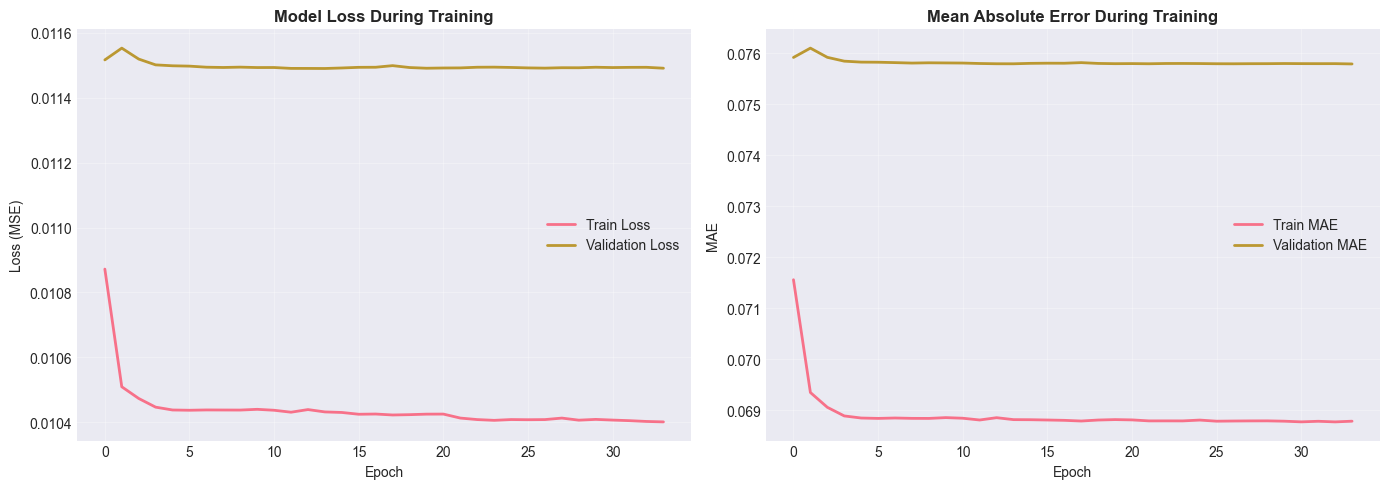

In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error During Training', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Generate Predictions

In [8]:
# Predict on test set
y_pred_scaled = model.predict(X_test_scaled, verbose=0)

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

print(f"✓ Generated predictions for {len(y_pred)} test sequences")
print(f"Each prediction contains {forecast_horizon} future values")

✓ Generated predictions for 2110 test sequences
Each prediction contains 5 future values


## 8. Convert to Price Forecasts

In [9]:
# Convert log returns to prices (CORRECTED: No look-ahead bias)
predictions_price = []
actuals_price = []

# Get test start index
test_start_idx = train_size + lookback

for i in range(len(y_pred)):
    # Get starting price (last known price before forecast)
    start_idx = test_start_idx + i
    last_known_price = df['GOLD_PRICE'].iloc[start_idx - 1]
    
    # Convert log returns to prices
    for j in range(forecast_horizon):
        # Predict price for day j based on last known price
        pred_price = last_known_price * np.exp(y_pred[i, j])
        actual_price = df['GOLD_PRICE'].iloc[start_idx + j]
        
        predictions_price.append(pred_price)
        actuals_price.append(actual_price)
        
        # CRITICAL FIX: Use ACTUAL price (not prediction) for next day's forecast
        # This simulates real-world scenario where we know past prices
        if j < forecast_horizon - 1:  # Only update if not last step
            last_known_price = actual_price

print(f"✓ Converted to {len(predictions_price)} price forecasts")
print(f"✓ Fixed: Using actual prices (not predictions) as base for multi-step forecasts")


✓ Converted to 10550 price forecasts
✓ Fixed: Using actual prices (not predictions) as base for multi-step forecasts


## 9. Evaluate Model Performance

In [10]:
# Calculate metrics on PRICES
rmse = np.sqrt(mean_squared_error(actuals_price, predictions_price))
mae = mean_absolute_error(actuals_price, predictions_price)

# Load previous model results
try:
    arima_results = pd.read_csv('../models/arima_baseline_results.csv')
    arima_garch_results = pd.read_csv('../models/arima_garch_results.csv')
    
    rmse_arima = arima_results['rmse'].values[0]
    mae_arima = arima_results['mae'].values[0]
    rmse_garch = arima_garch_results['rmse'].values[0]
    mae_garch = arima_garch_results['mae'].values[0]
    rmse_naive = arima_results['rmse_naive'].values[0]
    mae_naive = arima_results['mae_naive'].values[0]
    
    print("="*70)
    print("COMPREHENSIVE MODEL COMPARISON - 5-DAY AHEAD FORECASTS")
    print("="*70)
    print(f"\nLSTM Deep Learning:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"\nARIMA-GARCH Hybrid:")
    print(f"  RMSE: ${rmse_garch:.2f}")
    print(f"  MAE:  ${mae_garch:.2f}")
    print(f"\nARIMA Baseline:")
    print(f"  RMSE: ${rmse_arima:.2f}")
    print(f"  MAE:  ${mae_arima:.2f}")
    print(f"\nNaive Benchmark:")
    print(f"  RMSE: ${rmse_naive:.2f}")
    print(f"  MAE:  ${mae_naive:.2f}")
    
    print(f"\n" + "="*70)
    print("LSTM vs Statistical Models:")
    print("="*70)
    print(f"  vs ARIMA-GARCH: {(1 - rmse/rmse_garch)*100:+.2f}% (RMSE)")
    print(f"  vs ARIMA:       {(1 - rmse/rmse_arima)*100:+.2f}% (RMSE)")
    print(f"  vs Naive:       {(1 - rmse/rmse_naive)*100:+.2f}% (RMSE)")
    print("="*70)
except:
    print("⚠ Previous results not found")
    print(f"\nLSTM Results:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")

⚠ Previous results not found

LSTM Results:
  RMSE: $18.65
  MAE:  $12.65


## 10. Visualize LSTM Forecasts

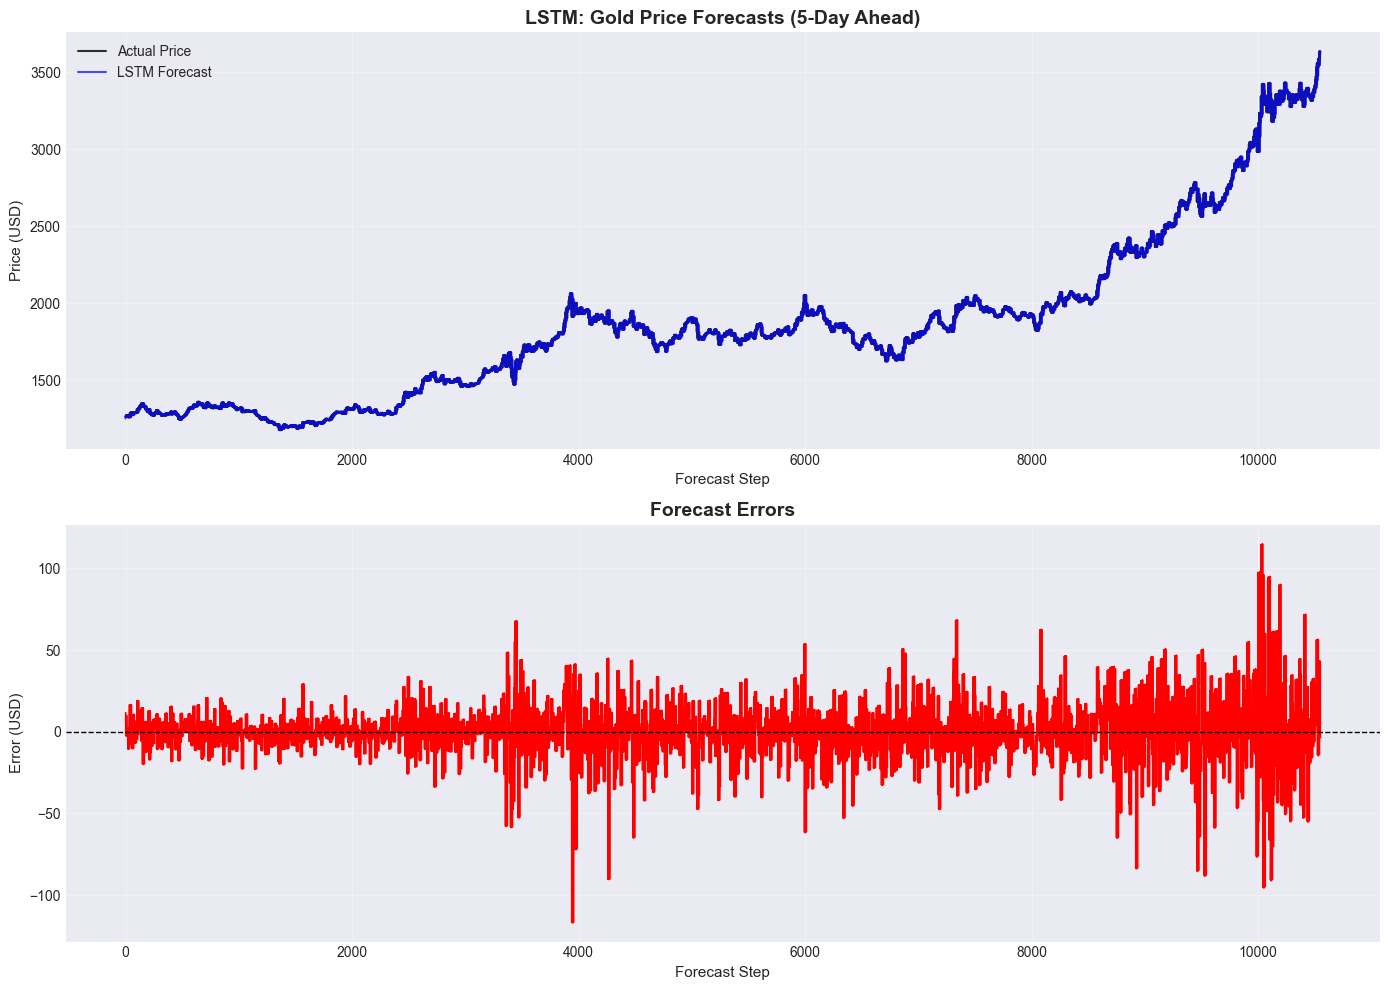

In [11]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price forecasts
forecast_indices = range(len(predictions_price))
axes[0].plot(forecast_indices, actuals_price, label='Actual Price', color='black', linewidth=1.5, alpha=0.8)
axes[0].plot(forecast_indices, predictions_price, label='LSTM Forecast', color='blue', linewidth=1.5, alpha=0.7)
axes[0].set_title('LSTM: Gold Price Forecasts (5-Day Ahead)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].set_xlabel('Forecast Step', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = np.array(actuals_price) - np.array(predictions_price)
axes[1].plot(forecast_indices, errors, color='red', linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(forecast_indices, errors, 0, alpha=0.3, color='red')
axes[1].set_title('Forecast Errors', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (USD)', fontsize=11)
axes[1].set_xlabel('Forecast Step', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Error Distribution Analysis

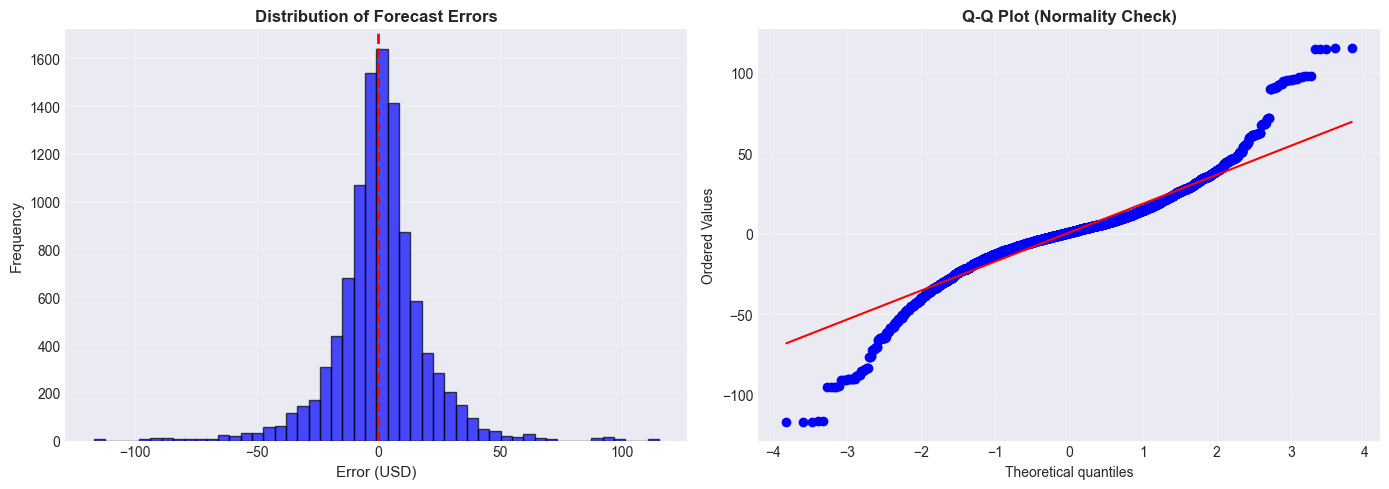

Error Statistics:
  Mean:     $0.63
  Std Dev:  $18.64
  Skewness: -0.0697
  Kurtosis: 5.3381


In [12]:
# Analyze error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Distribution of Forecast Errors', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Error (USD)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean:     ${np.mean(errors):.2f}")
print(f"  Std Dev:  ${np.std(errors):.2f}")
print(f"  Skewness: {stats.skew(errors):.4f}")
print(f"  Kurtosis: {stats.kurtosis(errors):.4f}")

## 12. Save Model and Results

In [13]:
# Create directory for saving results
import os
model_dir = '../models/lstm-deep-learning'
os.makedirs(model_dir, exist_ok=True)

# Save results
results = {
    'model': 'LSTM',
    'rmse': rmse,
    'mae': mae,
    'n_predictions': len(predictions_price),
    'lookback': lookback,
    'forecast_horizon': forecast_horizon,
    'lstm_units_1': 64,
    'lstm_units_2': 32
}

results_df = pd.DataFrame([results])
results_df.to_csv(f'{model_dir}/results.csv', index=False)

# Save model
model.save(f'{model_dir}/model.h5')

# Save scalers
import joblib
joblib.dump(scaler_X, f'{model_dir}/scaler_X.pkl')
joblib.dump(scaler_y, f'{model_dir}/scaler_y.pkl')

print(f"✓ Model and results saved to '{model_dir}/'")
print("\nFiles created:")
print("  - results.csv")
print("  - model.h5")
print("  - scaler_X.pkl")
print("  - scaler_y.pkl")

✓ Model and results saved to '../models/lstm-deep-learning/'

Files created:
  - results.csv
  - model.h5
  - scaler_X.pkl
  - scaler_y.pkl


## 13. Final Model Comparison Summary

In [14]:
# Create comprehensive comparison table
try:
    comparison_data = {
        'Model': ['Naive Baseline', 'ARIMA', 'ARIMA-GARCH', 'LSTM'],
        'RMSE ($)': [rmse_naive, rmse_arima, rmse_garch, rmse],
        'MAE ($)': [mae_naive, mae_arima, mae_garch, mae],
        'Type': ['Statistical', 'Statistical', 'Statistical', 'Deep Learning'],
        'Volatility Forecast': ['No', 'No', 'Yes', 'No'],
        'Exogenous Variables': ['No', 'No', 'No', 'No'],
        'Interpretability': ['High', 'High', 'Medium', 'Low']
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('RMSE ($)')
    
    print("="*80)
    print("FINAL MODEL COMPARISON - GOLDENHOUR PROJECT")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Save comparison
    comparison_dir = '../models/comparison'
    os.makedirs(comparison_dir, exist_ok=True)
    comparison_df.to_csv(f'{comparison_dir}/model_comparison.csv', index=False)
    print(f"\n✓ Comparison saved to {comparison_dir}/model_comparison.csv")
except:
    print("⚠ Could not create full comparison (missing previous results)")

⚠ Could not create full comparison (missing previous results)


## 14. Key Findings

**LSTM Characteristics**:
- **Strengths**:
  - Captures non-linear patterns
  - No stationarity assumptions
  - Can handle complex temporal dependencies
  
- **Weaknesses**:
  - Black box (low interpretability)
  - Requires substantial training data
  - Computationally expensive
  - Prone to overfitting
  - No theoretical foundation (unlike ARIMA)

**When to Use LSTM vs ARIMA**:
- **Use LSTM**: Complex non-linear relationships, large datasets, computational resources available
- **Use ARIMA**: Interpretability needed, smaller datasets, academic rigor required, statistical inference desired

**For Academic Project**: ARIMA-GARCH recommended due to:
1. Solid theoretical foundation
2. Interpretable coefficients
3. Volatility forecasting capability
4. Well-documented in econometrics literature